In [1]:
# !pip install pandas
# !pip install watermark
# !pip install seaborn
# !pip install biopython
# !pip install sklearn
import os
import re 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np 
import watermark
import random 
import math
# from tqdm.notebook import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
%load_ext watermark
%watermark
%watermark --iversion

Last updated: 2021-06-10T22:56:25.665615+08:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 11, GenuineIntel
CPU cores   : 8
Architecture: 64bit

pandas    : 1.2.4
seaborn   : 0.11.1
matplotlib: 3.3.4
watermark : 2.2.0
re        : 2.2.1
numpy     : 1.20.1



In [5]:
# 加载变量
left=3
right=6
output_name = "WAMoutput"
train_features_df = pd.read_csv(f'{output_name}/Train_features.csv')
test_file_df = pd.read_csv(f"{output_name}/Test_predict.csv")
test_features_df = pd.read_csv(f"{output_name}/Test_features.csv")

In [6]:
# 全局变量设定
signal_num = left+right
bases="ACGT"
lower_bases="acgt"
pattern = re.compile("[^acgt]")

In [7]:
train_donor_signal_int=np.array(train_features_df[train_features_df['Label']==1].iloc[:,:-1])


### Nucleotide Distribution Probabilities 

In [11]:
train_donor_signal_int

array([[0, 2, 3, ..., 0, 2, 3],
       [3, 3, 1, ..., 0, 2, 3],
       [0, 2, 2, ..., 0, 2, 0],
       ...,
       [0, 1, 0, ..., 0, 2, 3],
       [2, 0, 0, ..., 0, 2, 3],
       [1, 0, 2, ..., 0, 1, 3]], dtype=int64)

Calculating Prior Probability:: 100%|██████████████████████████████████████████████████| 9/9 [00:00<00:00, 8983.52it/s]


        p(A)      p(C)      p(G)      p(T)
-3  0.328433  0.363713  0.188576  0.119278
-2  0.585468  0.137757  0.133557  0.143217
-1  0.094078  0.034019  0.788744  0.083158
 0  0.000000  0.000000  1.000000  0.000000
 1  0.000000  0.000000  0.000000  1.000000
 2  0.490130  0.027299  0.458211  0.024360
 3  0.713566  0.077278  0.117598  0.091558
 4  0.065099  0.049559  0.838303  0.047039
 5  0.151197  0.162957  0.216716  0.469131


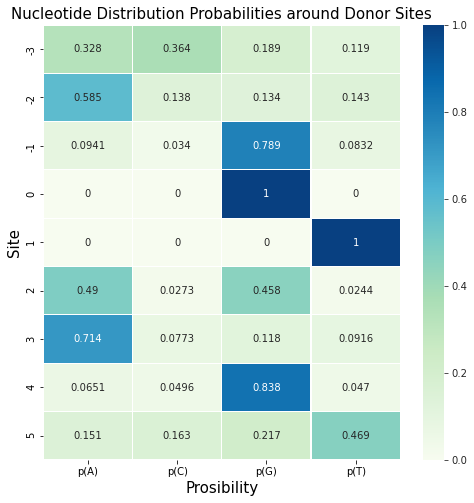

In [9]:

def cal_priorProbability(donor_signal) :
    """
    为了优化计算先验概率的性能，导致现在不能输入非atcg的了……
    """
    count= np.zeros((signal_num,4),dtype=np.int32)
    cols = tqdm(range(signal_num), desc='Calculating Prior Probability:')
    for col in cols:
        count[col]=np.bincount(donor_signal[:,col],minlength=4)[0:4]
#         count[col]=np.unique(donor_signal[:,col],return_counts=True)[1][0:4]
#     print(count)
    priors = count/len(donor_signal)
    cols.close()
    return priors

def prior_to_csv(priors,signal,mode):
    pri_col_name = [f'p({base})' for base in bases ]
    if signal=="acceptor":
        pri_row_name = list(range(-right+1,left+1))
    else:
        pri_row_name= list(range(-left,right))
    priorDf= pd.DataFrame(index=pri_row_name,columns=pri_col_name, data=priors)
    print(priorDf)  
    if signal=="nonDonor":
        priorDf.to_csv(f'{output_name}/prior_probability_(P{mode}).csv')
    else:
        priorDf.to_csv(f'{output_name}/{signal}_prior_probability_(P{mode}).csv')
    return priorDf

def ShowHeatMap(DataFrame,title="HeatMap",size=(8, 8),color='GnBu'):
    """
    # ylabels = DataFrame.columns.values.tolist() #保存df的列名为label
    # 数据的index和columns分别为heatmap的y轴方向和x轴方向标签
    # cmap=sns.light_palette("#2ecc71", as_cmap=True)
    #x轴方向刻度标签开关、赋值，可选“auto”, bool, list-like（传入列表）, or int
    xticklabels=['三连啊','关注公众号啊','pythonic生物人','收藏啊','点赞啊','老铁三连三连'] ,
     #y轴方向刻度标签开关、同x轴
            yticklabels=True
    colormap = plt.cm.RdBu,"YlGnBu" # 颜色映射
    """
    

    f, ax = plt.subplots(figsize=size)
    ax.set_title(title,fontsize=15)
    with sns.axes_style("white"):
        sns.heatmap(DataFrame,
                    cmap=color,  
                    annot=True, # show num
                    fmt='.3g',# num format
                    linewidths=.2,
                    yticklabels=True,
                    xticklabels=True,
                   )
    
    ax.set_ylabel("Site",fontsize=15)
    ax.set_xlabel("Prosibility",fontsize=15)
    f.savefig(f"{output_name}/{title}-left{left}-right{right}.png",dpi=400)


donor_priors_p=cal_priorProbability(train_donor_signal_int)
df_donor_priors_p=prior_to_csv(donor_priors_p,signal="donor",mode="+")
ShowHeatMap(df_donor_priors_p,title="Nucleotide Distribution Probabilities around Donor Sites")

### Dependence between Adjacent Base Pairs

Calculating Conditional Probability:: 100%|█████████████████████████████████████| 2381/2381 [00:00<00:00, 18363.70it/s]


      p(A,A)    p(A,C)    p(A,G)    p(A,T)    p(C,A)    p(C,C)    p(C,G)  \
-2  0.616368  0.097187  0.149616  0.136829  0.677829  0.123557  0.058891   
-1  0.073888  0.018651  0.854376  0.053085  0.189024  0.070122  0.524390   
 0  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000  1.000000   
 1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 3  0.646101  0.095973  0.121680  0.136247  0.676923  0.030769  0.107692   
 4  0.057681  0.027075  0.882284  0.032961  0.163043  0.222826  0.429348   
 5  0.212903  0.135484  0.445161  0.206452  0.296610  0.288136  0.118644   

      p(C,T)    p(G,A)    p(G,C)    p(G,G)    p(G,T)    p(T,A)    p(T,C)  \
-2  0.139723  0.608018  0.167038  0.124722  0.100223  0.183099  0.246479   
-1  0.216463  0.147799  0.066038  0.707547  0.078616  0.035191  0.032258   
 0  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
 1  0.00000

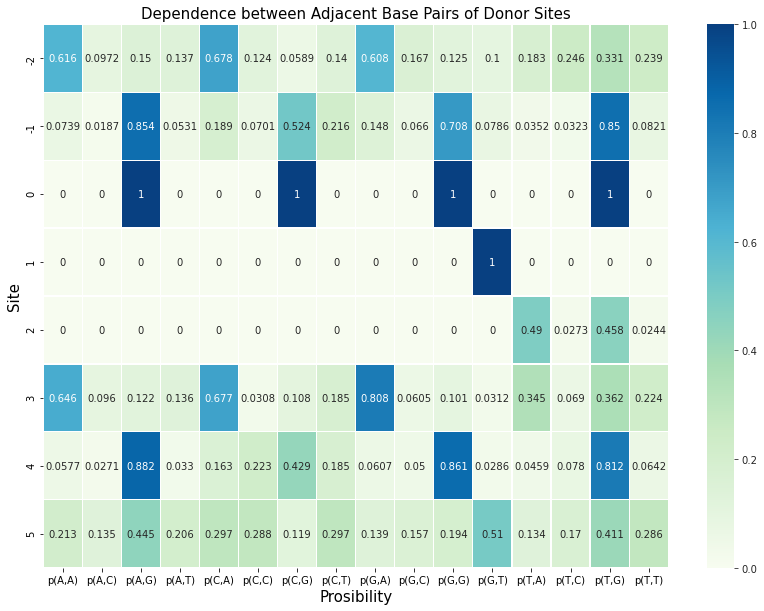

In [17]:
import itertools
def joint_count(donor,count):
    for j in range(8):
        code1,code2 = donor[j:j+2]
        pos = 4*code1+code2
        count[j][pos] +=1
    return count
     

def cal_conditionalProbability(donor_signal,priors):
    N,M=signal_num-1,16
    count= np.zeros((N,M),dtype=np.int32)
    conditional = np.zeros((N,M),dtype=np.float32)
    donor_signal = tqdm(donor_signal, desc='Calculating Conditional Probability:')
    for donor in donor_signal:
        for j in range(N):
            if 4 not in donor[j:j+1]:
                count[j][4*donor[j]+donor[j+1]] +=1
            else:
                pass 
    #  joint
    joint= count/(len(donor_signal))
    
    # conditional P(i+1,A|i,C) = P(A,C)/P(C) 
    for k in itertools.product(range(N),range(4),range(4)):
        i = k[0]
        j = k[1]
        m = k[2]
        if priors[i][j]:
            conditional[i][4*j+m] = joint[i][4*j+m]/priors[i][j]
        else:
            pass
    return conditional

def conditional_to_csv(conditional,signal,mode):
    conditional_col_name = [f'p({i},{j})' for i in bases for j in bases ]
    conditional_row_name=list(range(-left+1,right))
    conditionalDf= pd.DataFrame(index=conditional_row_name,columns=conditional_col_name, data=conditional)
    print(conditionalDf) 
    if signal=="nonDonor":
        conditionalDf.to_csv(f'{output_name}/conditionalDf_probability(P{mode}).csv')
    else:
        conditionalDf.to_csv(f'{output_name}/{signal}_conditionalDf_probability(P{mode}).csv')
    return conditionalDf
    
donor_conditional_p = cal_conditionalProbability(train_donor_signal_int,donor_priors_p)
df_donor_conditional_p =conditional_to_csv(donor_conditional_p,signal="donor",mode="+")
ShowHeatMap(df_donor_conditional_p,size=(14,10),title="Dependence between Adjacent Base Pairs of Donor Sites")
# acceptor_conditional_p=cal_conditionalProbability(train_acceptor_signal_int,acceptor_priors_p)
# conditional_to_csv(acceptor_conditional_p,signal="acceptor",mode="+")


### pseudoDonor

In [18]:
nonDonor_array=np.array(train_features_df[train_features_df['Label']==0].iloc[:,:-1])

In [19]:

# signal_to_csv(nonDonor_array,mode="nonDonor") 
prior_n=cal_priorProbability(nonDonor_array)
df_prior_n = prior_to_csv(prior_n,signal="pseudoDonor",mode="-")
conditional_n = cal_conditionalProbability(nonDonor_array,prior_n)
df_conditional_n = conditional_to_csv(conditional_n,signal="pseudoDonor",mode="-")

Calculating Conditional Probability:: 100%|█████████████████████████████████████| 2379/2379 [00:00<00:00, 22144.36it/s]

        p(A)      p(C)      p(G)      p(T)
-3  0.245481  0.225305  0.239176  0.290038
-2  0.253888  0.244220  0.242539  0.259353
-1  0.290458  0.063472  0.256831  0.389239
 0  0.000000  0.000000  1.000000  0.000000
 1  0.000000  0.000000  0.000000  1.000000
 2  0.196301  0.202186  0.340479  0.261034
 3  0.247583  0.225305  0.241278  0.285834
 4  0.240858  0.259773  0.222362  0.277007
 5  0.251366  0.213535  0.235393  0.299706
      p(A,A)    p(A,C)    p(A,G)    p(A,T)    p(C,A)    p(C,C)    p(C,G)  \
-2  0.275685  0.202055  0.287671  0.234589  0.309702  0.315298  0.095149   
-1  0.276490  0.057947  0.321192  0.344371  0.370052  0.087780  0.058520   
 0  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000  1.000000   
 1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 3  0.289079  0.192719  0.256959  0.261242  0.293139  0.274428  0.072765   
 4  0.293718  0.232598  0.241087  0.23

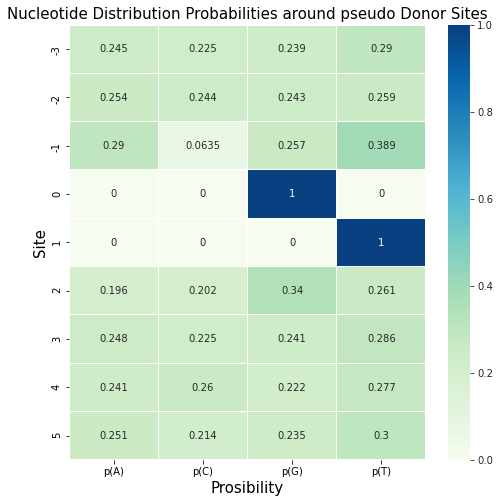

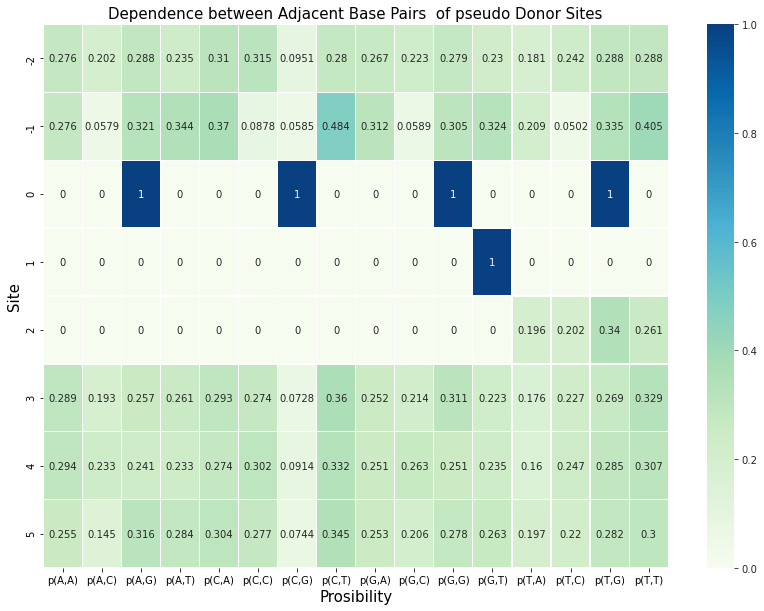

In [20]:
ShowHeatMap(df_prior_n,title="Nucleotide Distribution Probabilities around pseudo Donor Sites")
ShowHeatMap(df_conditional_n,size=(14,10),title="Dependence between Adjacent Base Pairs  of pseudo Donor Sites")

数据处理部分结束！😀😀😀😀😀😀😀😀😀😀😀😀😀

## WAM

In [13]:
# 读取概率矩阵
priorP=pd.read_csv("WAMoutput/donor_prior_probability_(P+).csv",index_col=[0])
priorN=pd.read_csv("WAMoutput/pseudoDonor_prior_probability_(P-).csv",index_col=[0])
conditionalP=pd.read_csv("WAMoutput/donor_conditionalDf_probability(P+).csv",index_col=[0])
conditionalN=pd.read_csv("WAMoutput/pseudoDonor_conditionalDf_probability(P-).csv",index_col=[0])
priorP = np.array(priorP)
priorN = np.array(priorN)
conditionalP = np.array(conditionalP)
conditionalN = np.array(conditionalN)
# 读取序列数据
donor_strs=np.loadtxt("WAMoutput/Train_donor_signal_str.txt",delimiter = ',',dtype='str')
pseudoDonor_strs=np.loadtxt("WAMoutput/Train_pseudoDonor_signal_str.txt",delimiter = ',',dtype='str')

In [14]:
def log_c(num,ex_mini=10e-15):
    if num == 0:
        return np.log(ex_mini)
    else:
        return np.log(num)

def process_donors(donors):
    char_to_int = {c:i for i, c in enumerate(lower_bases)}
    integer_encoded = [char_to_int[char] for char in donors]
    return np.array(integer_encoded)
    
def cal_WAM(seq, priorA=priorP[0], priorB=priorN[0], conditionalA=conditionalP, conditionalB=conditionalN):
    seq = process_donors(seq)
    S = np.log(priorA[seq[0]]) - np.log(priorB[seq[0]])
    for i in range(signal_num-1):
            S += log_c(conditionalA[i,seq[i]*4+seq[i+1]]) - log_c(conditionalB[i,seq[i]*4+seq[i+1]])
    return S


donor_strs = tqdm(donor_strs, desc='Calculating Donor signal score:')
scores=list(map(cal_WAM,donor_strs))


Calculating Donor signal score:: 100%|██████████████████████████████████████████| 2381/2381 [00:00<00:00, 21894.52it/s]


### 统计训练集分值分布

In [31]:
s1 = pd.Series(scores)
print(s1.describe())
s1.describe().to_csv("WAMoutput/donor_score_describe.csv")

count    2381.000000
mean        2.878553
std         1.539826
min        -4.743652
25%         1.888433
50%         2.869188
75%         4.151614
max         5.920373
dtype: float64


In [32]:
pseudoDonor_strs = tqdm(pseudoDonor_strs, desc='Calculating Non scores:')
pseudo_scores=list(map(cal_WAM,pseudoDonor_strs))

Calculating Non scores:: 100%|██████████████████████████████████████████████| 283607/283607 [00:13<00:00, 21354.97it/s]


In [33]:
s2 = pd.Series(pseudo_scores)
print(s2.describe())
s2.describe().to_csv("WAMoutput/pseudoDonor_score_describe.csv")

count    283607.000000
mean         -2.959476
std           2.304049
min          -8.020536
25%          -4.746650
50%          -3.081692
75%          -1.443744
max           5.920373
dtype: float64


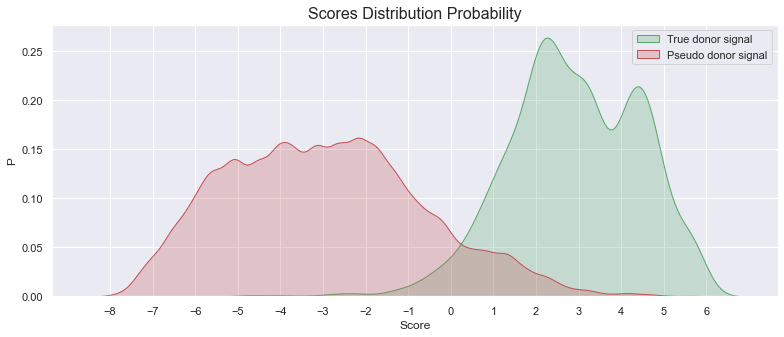

In [34]:
# 真假位点的分值分布图
sns.set(style='darkgrid')
fig,axes = plt.subplots(1,1,figsize=(13,5))
ax1 = sns.kdeplot(scores,shade=True,color="g",bw_adjust=1,cut=3,cumulative=False,label="True donor signal",ax=axes)
ax1 = sns.kdeplot(pseudo_scores,shade=True,color="r",bw_adjust=1,cut=3,cumulative=False,label="Pseudo donor signal",ax=axes)
ax1.set_ylabel('P')
ax1.set_xlabel("Score")
ax1.set_xticks(np.arange(-8,7,1))
ax1.legend()
ax1.set_title('Scores Distribution Probability',fontsize=16)
fig.savefig(f'WAMoutput/Distribution_Probability.png',dpi = 200) #路径+文件名

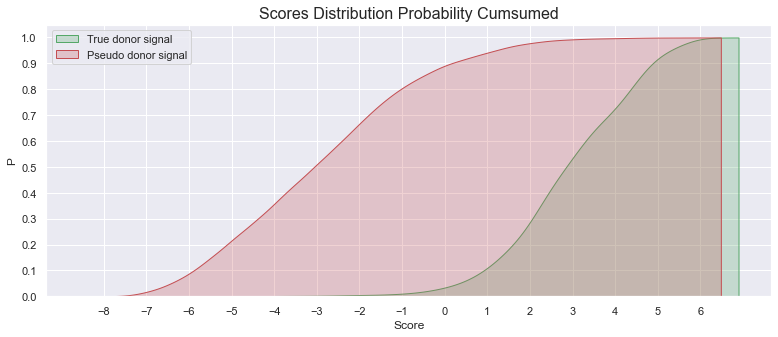

In [35]:
# 真假位点的分值累计分布图
sns.set(style='darkgrid')
fig,axes = plt.subplots(1,1,figsize=(13,5))
ax1 = sns.kdeplot(scores,shade=True,color="g",bw_adjust=1,cut=3,cumulative=True,label="True donor signal",ax=axes)
ax1 = sns.kdeplot(pseudo_scores,shade=True,color="r",bw_adjust=1,cut=3,cumulative=True,label="Pseudo donor signal",ax=axes)
ax1.set_ylabel('P')
ax1.set_xlabel("Score")
ax1.set_yticks(np.arange(0,1.1,0.1))
ax1.set_xticks(np.arange(-8,7,1))
ax1.legend(loc="upper left")
ax1.set_title('Scores Distribution Probability Cumsumed',fontsize=16)
fig.savefig(f'WAMoutput/Distribution_Probability_Cumsumed.png',dpi = 200) #路径+文件名

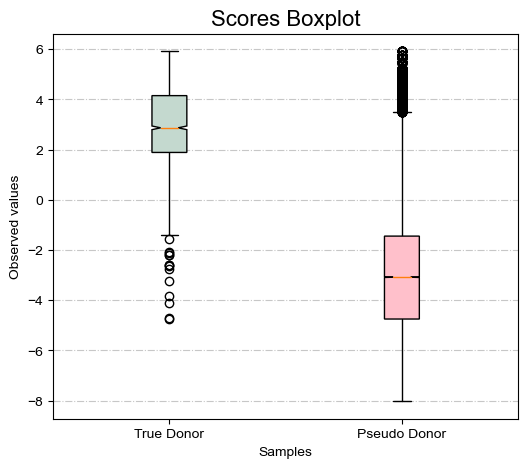

In [36]:
# 箱式图
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('default')
fig = plt.figure(figsize=(6,5))  # 创建画布
ax = plt.subplot()  # 创建作图区域
# 蓝色矩形的红线：50%分位点是4.5,上边沿：25%分位点是2.25,下边沿：75%分位点是6.75
plt.style.use('seaborn-darkgrid')
labels = ['True Donor', 'Pseudo Donor']
colors = ['#c4d9cf', 'pink']
bplot =ax.boxplot([scores,pseudo_scores],patch_artist=True,  labels=labels,notch=True)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)  # 为不同的箱型图填充不同的颜色
plt.grid(linestyle='-.',alpha=0.7)
# plt.grid(b=True, axis='y') #只显示y轴网格线
plt.grid(axis="x")
plt.xlabel('Samples')
plt.ylabel('Observed values')
plt.title('Scores Boxplot',fontsize=16)
# plt.yticks(np.arange(-8,7,1))
plt.show()
fig.savefig("WAMoutput/Plot_boxplot.png",dpi=120)

### 计算测试集scores

In [41]:
test_file_df

,Filename,Donor Site,Signal,label
0,Testing Set/ACU08131.TXT,642,ggggtgagc,1
1,Testing Set/ACU08131.TXT,1363,gtggtaaga,1
2,Testing Set/ACU08131.TXT,2029,taggtgagt,1
3,Testing Set/ACU08131.TXT,2803,gcggtaggt,1
4,Testing Set/ACU08131.TXT,3798,caggtaatt,1
...,...,...,...,...
151280,Testing Set/ZEFB2MICB.txt,2123,taagttaaa,0
151281,Testing Set/ZEFB2MICB.txt,2145,atagtggcc,0
151282,Testing Set/ZEFB2MICB.txt,2159,tgagtttct,0
151283,Testing Set/ZEFB2MICB.txt,2165,tctgttatg,0


In [45]:
test_labels = test_file_df["label"]

In [38]:
test_strs = tqdm(test_file_df["Signal"], desc='Calculating Non scores:')
test_scores=list(map(cal_WAM,test_strs))

Calculating Non scores:: 100%|██████████████████████████████████████████████| 151285/151285 [00:06<00:00, 21825.63it/s]


In [39]:
# 计算测试集分值并保存
predict_scores = pd.Series(test_scores)
print(predict_scores .describe())
predict_scores.describe().to_csv("WAMoutput/predict_scores.csv")
predict_scores.to_csv("WAMoutput/WAM_predict_scores.csv",index=None)

count    151285.000000
mean         -2.872166
std           2.390173
min          -8.020536
25%          -4.707391
50%          -2.992399
75%          -1.375549
max           5.920373
dtype: float64


### Evaluation

In [50]:
from sklearn.metrics import confusion_matrix
def save_to_file(file_name, contents,mode='a+'):
    fh = open(file_name, mode)
    fh.write(contents)
    fh.close()
def draw_confusion_matrix(labels,predicts,name,size=(6, 6),mode='a+',threshold="Default"):
    mat = confusion_matrix(labels,predicts)
    TP = mat[1][1]
    FP = mat[0][1]
    TN = mat[0][0]
    FN = mat[1][0]
    recall  = TP/(FN+TP)
    precision = TP/(FP+TP)
    acc = (TP+TN)/np.sum(mat)
    fpr =  FP/(TN+ FP)
    f1_score = 2*precision*recall/(precision+recall)
    print(f"Precision :{precision}, Recall:{recall},f1_score:{f1_score},Acc:{acc},FPR:{fpr},Sp:{1-fpr}")
    save_to_file('WAMoutput/WAM_predict.txt', f"\nPrecision :{precision}, Recall:{recall},f1_score:{f1_score},Acc:{acc} \n",mode)

    f, ax = plt.subplots(figsize=size)
    sns.set()
    sns.heatmap(mat, square=True, annot=True, fmt='d',cmap='Blues' ,cbar=False,
                xticklabels=['pseudo donor','real donor'],
                yticklabels=['pseudo donor','real donor'],)
    ax.set_xlabel(f'Predicted label\nPrecision :{precision:.2f}, Recall:{recall:.2f},F1_score:{f1_score:.2f}')
    ax.set_ylabel(f'True label');
    plt.title(f"Confusion Matrix(Threshold:{threshold})\n",fontsize=15)
    f.savefig(f"WAMoutput/{name}.png",dpi=120)

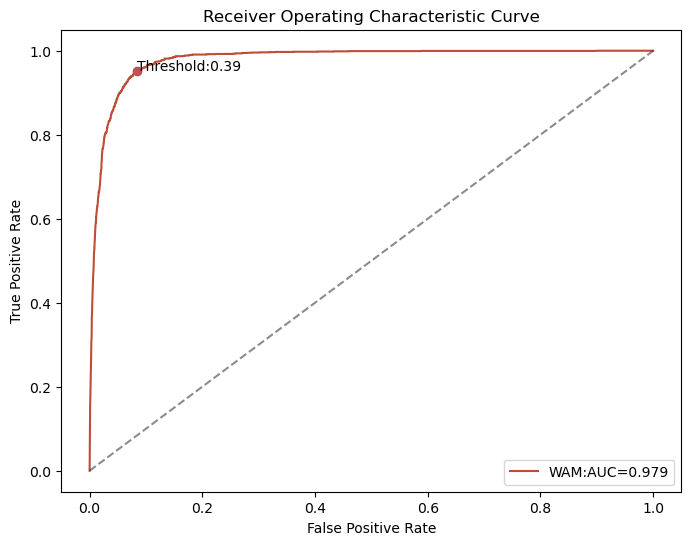

In [53]:
# ROC plot
# problem ： 如何画不同核的图在一个图里
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import matplotlib.pyplot as plt
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

def ROC_plot(label, y_prob):
    fpr, tpr, thresholds = roc_curve(label, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"WAM:AUC={roc_auc:.3f}",color='#ad2102',alpha=0.8)
    plt.plot([0, 1], [0, 1],"k--",alpha=0.5)
    plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
    plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
    plt.title("Receiver Operating Characteristic Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    f = plt.gcf()  #获取当前图像
    f.savefig(f'{output_name}/ROC_plot.png',dpi=120)
    plt.show()
    return optimal_th

plt.style.use('default')

optimal_th=ROC_plot(test_labels,test_scores)



Precision :0.13613861386138615, Recall:0.9523809523809523,f1_score:0.23822414726583646,Acc:0.9162970552268896,FPR:0.08420572899213169,Sp:0.9157942710078684


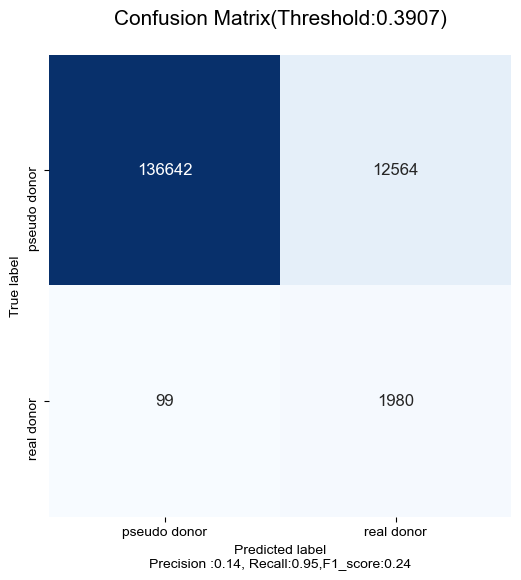

In [54]:
best_predict_label =[1 if i >optimal_th else 0 for i in test_scores ]
draw_confusion_matrix(test_labels, best_predict_label,name=f"confusion_matrix_p_{optimal_th:.4f}",threshold=f'{optimal_th:.4f}')

[0.01525513 0.01525194 0.01525641 ... 0.55102041 0.44       1.        ]


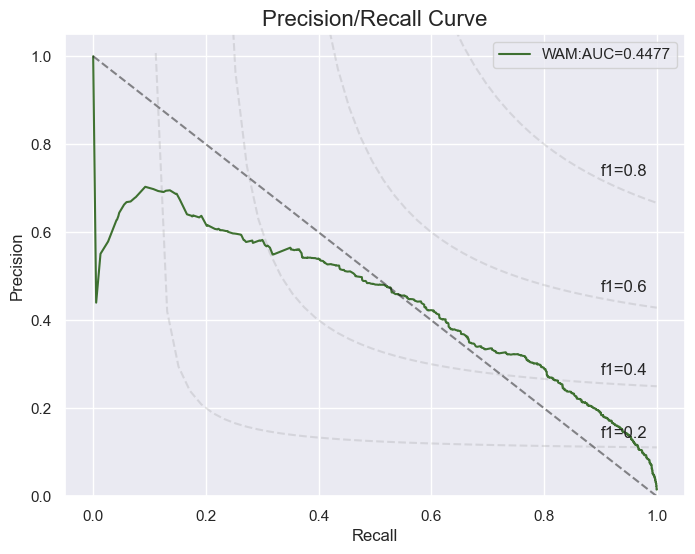

In [56]:
from sklearn.metrics import precision_recall_curve


def plot_pr(labels, predict_probs):
    plt.figure(figsize=(8, 6))
    precision, recall, thresholds = precision_recall_curve(labels, predict_probs)
    pr_auc=auc(recall, precision)
    print(precision)
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray',linestyle='--' ,alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        
    plt.plot(recall,precision,'b',label=f'WAM:AUC={pr_auc:.4f}', alpha=0.8,color="#135200")  
    plt.legend(loc='lower right')
    plt.plot([0,1],[1,0],'k--',alpha=0.5)
    plt.title('Precision/Recall Curve',fontsize=16)# give plot a title
    plt.xlabel('Recall')# make axis labels
    plt.ylabel('Precision')
    plt.ylim(0,1.05)
    plt.legend(loc="upper right")
    f = plt.gcf()  #获取当前图像
    f.savefig(f'{output_name}/Plot_PR.png',dpi=120)
    plt.show()
    return thresholds
thresholds=plot_pr(test_labels,test_scores)

# y_true = np.array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])
# y_scores = np.array([0.9, 0.75, 0.86, 0.47, 0.55, 0.56, 0.74, 0.62, 0.5, 0.86, 0.8, 0.47, 0.44, 0.67, 0.43, 0.4, 0.52, 0.4, 0.35, 0.1])
# plot_pr(y_true ,y_scores)

In [58]:
thresholds =np.arange(-9,7,0.1)
def sum_threshold_info(test_labels,pred,thresholds):
    TPs  = []
    FPs = []
    TNs = []
    FNs = []
    for threshold in thresholds:
        predict_label =[1 if i >= threshold else 0 for i in pred ]
        mat = confusion_matrix(test_labels,predict_label)
        TP = mat[1][1]
        FP = mat[0][1]
        TN = mat[0][0]
        FN = mat[1][0]

        TPs.append(TP)
        FPs.append(FP)
        TNs.append(TN)
        FNs.append(FN)
    predict_df = pd.DataFrame({"Threshold":thresholds,"TP":TPs,"FP":FPs,"TN":TNs,"FN":FNs})
    predict_df["Recall"] = predict_df["TP"] /(predict_df["TP"]+predict_df["FN"])
    predict_df["Precision"] = predict_df["TP"] /(predict_df["TP"]+predict_df["FP"])
    predict_df["F1-Score"] = 2*predict_df["Recall"]*predict_df["Precision"] /(predict_df["Recall"]+predict_df["Precision"])
    predict_df["Sn"] = predict_df["TN"] /(predict_df["TN"]+predict_df["FP"])
    predict_df["FPR"] =  1- predict_df["Sn"]
    predict_df["Acc"] =  (predict_df["TP"] + predict_df["TN"]) / (predict_df["TP"] + predict_df["TN"]+predict_df["FP"] + predict_df["FN"])
    return predict_df
WAMpredict_df=sum_threshold_info(test_labels,test_scores,thresholds)
WAMpredict_df.to_csv(f"{output_name}/Predict_info.csv",index=None)
WAMpredict_df

2.799999999999958


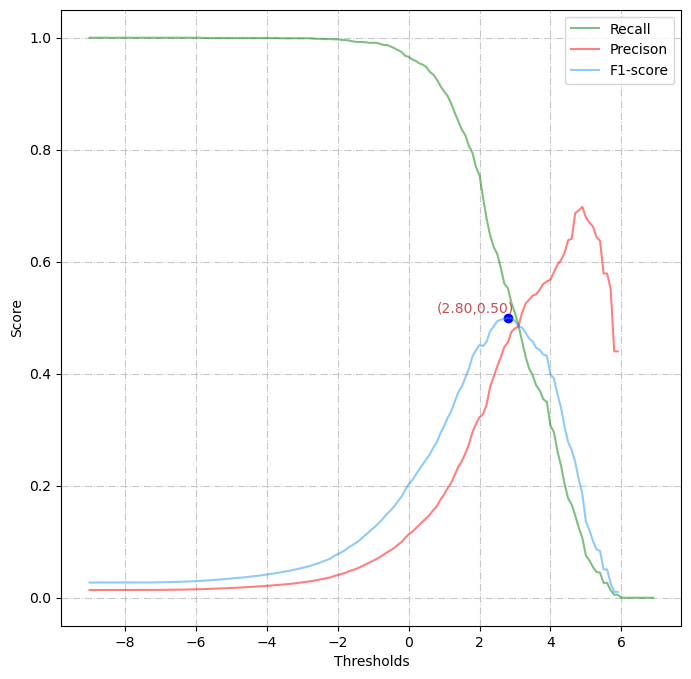

In [59]:
def plot_PRF(predict_df):
    f, ax = plt.subplots(figsize=(8,8))
    alpha=0.5
    ymax = predict_df["F1-Score"].max()
    xmax = thresholds[predict_df["F1-Score"].idxmax()]
    print(xmax)
    plt.scatter(xmax,ymax,color='blue')
    plt.text(xmax-2,ymax+0.01,f"({xmax:.2f},{ymax:.2f})",color='r')
    plt.plot(thresholds,predict_df["Recall"], color='green', label='Recall',alpha=alpha)
    plt.plot(thresholds, predict_df["Precision"], color='red', label='Precison',alpha=alpha)
    plt.plot(thresholds, predict_df["F1-Score"], color='#2196f3', label='F1-score',alpha=alpha)
    plt.xlabel("Thresholds")
    plt.ylabel("Score")
#     plt.xticks(np.arange(0,1.1,0.1))
#     plt.yticks(np.arange(0,1.1,0.1))
#     plt.xlim([-0.05,0.9])
    plt.legend(loc="upper right") # 图标在外侧
    plt.grid(linestyle='-.',alpha=0.7)
    plt.show()
   
    return f,xmax
plt.style.use("default")
f,th=plot_PRF(WAMpredict_df)
f.savefig(f"{output_name}/Different Threshold Predictions.png",dpi=120)

Precision :0.45595238095238094, Recall:0.5526695526695526,f1_score:0.4996738421395956,Acc:0.9847902964603232,FPR:0.009188638526600807,Sp:0.9908113614733992


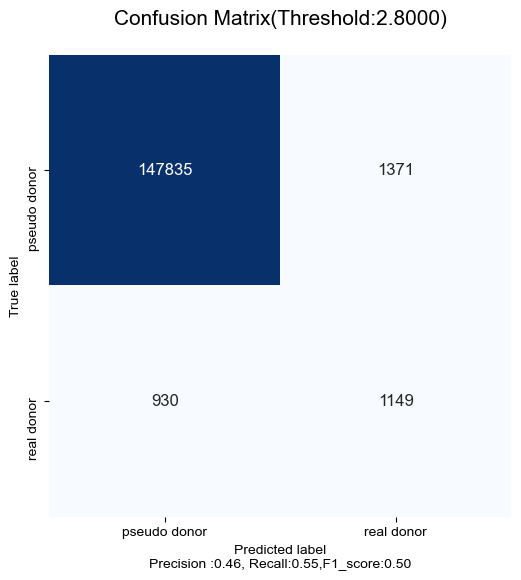

In [60]:

predict_label =[1 if i >th else 0 for i in test_scores ]
draw_confusion_matrix(test_labels, predict_label,name=f"confusion_matrix_p_{th:.4f}",threshold=f'{th:.4f}')